# Retrieving image cutouts from r-dropouts in SMASH


## Summary
In this notebook, we will look for objects that are detected in i and z in SMASH and in ALLWISE, but are undetected in u, g, and r.

## Image cutouts
We'll pick out some promising dropout candidates, and show how to call the Simple Image Access (SIA) service to get cutouts for them.

## Known issues
The notebook only retrieves cutouts for one object.  In order to retrieve cutouts for all candidates, the SIA service needs to be called in a loop.


### Initialization

We begin by importing the requisite libraries and getting the authorization token for the Query Client

In [1]:
print "Start"
import numpy as np
import sys

import pandas as pd
from cStringIO import StringIO
from dl import authClient
from dl import queryClient
from pyvo.dal import sia

import matplotlib.pyplot as plt
import astropy.utils
%matplotlib inline

# Get the security token for the datalab demo user
token = authClient.login('anonymous')
print "Got token",token

Start
Got token anonymous.0.0.anon_access


### Catalog query

For our query, we will look for objects that are undetected or have large errors in u, g, and r, but are detected and have small errors in i and z.

In [45]:
db1='smash_dr1.object' # the SMASH object table with average magnitudes
db1sel='db1.fieldid,db1.id,db1.ra,db1.dec,db1.umag,db1.gmag,db1.rmag,db1.imag,' +\
    'db1.zmag,db1.uerr,db1.gerr,db1.rerr,db1.ierr,db1.zerr,db1.depthflag' # select ID, coordinates, and mags
db2='smash_dr1.xmatch' # the SMASH cross-match table, which contains cross-matches to ALLWISE
db2sel='db2.wise_id,db2.wise_w1mag,db2.wise_w1err,db2.wise_w2mag,db2.wise_w2err' # ALLWISE W1 mags
db1where='(db1.depthflag > 1 and (db1.ndetu=0 or db1.uerr>0.3) and ' + \
        ' (db1.ndetg=0 or db1.gerr>0.3) and ' + \
        ' (db1.ndetr=0 or db1.rerr>0.3) and ' + \
        ' (db1.ndeti>0 and db1.ierr<0.1) and ' + \
        ' (db1.ndetz>0 and db1.zerr<0.1))' # pick ugr dropouts
db2where='(db1.id=db2.id and db2.wise_match=1)' # only pick dropouts that are found in ALLWISE W1

# Create the query string.
query = 'SELECT '+db1sel+','+db2sel+' FROM '+db1+' AS db1,'+db2+' AS db2 WHERE ('+db1where+' and '+db2where+')'
        
#query = ('select fieldid,id,'+raname+','+decname+','+mags+',depthflag from '+dbase+ \
#        ' where (depthflag > %d and ' + \
#        ' (ndetu=0 or uerr>0.3) and ' + \
#        ' (ndetg=0 or gerr>0.3) and ' + \
#        ' (ndetr=0 or rerr>0.3) and ' + \
#        ' (ndeti>0 and ierr<0.1) and ' + \
#        ' (ndetz>0 and zerr>0.1))') % \
#           (depth)
        
print "Your query is:", query
print "Making query"

# Call the Query Manager Service    
response = queryClient.query(token, adql = query, fmt = 'csv')
df = pd.read_csv(StringIO(response))

print len(df), "objects found."

Your query is: SELECT db1.fieldid,db1.id,db1.ra,db1.dec,db1.umag,db1.gmag,db1.rmag,db1.imag,db1.zmag,db1.uerr,db1.gerr,db1.rerr,db1.ierr,db1.zerr,db1.depthflag,db2.wise_id,db2.wise_w1mag,db2.wise_w1err,db2.wise_w2mag,db2.wise_w2err FROM smash_dr1.object AS db1,smash_dr1.xmatch AS db2 WHERE ((db1.depthflag > 1 and (db1.ndetu=0 or db1.uerr>0.3) and  (db1.ndetg=0 or db1.gerr>0.3) and  (db1.ndetr=0 or db1.rerr>0.3) and  (db1.ndeti>0 and db1.ierr<0.1) and  (db1.ndetz>0 and db1.zerr<0.1)) and (db1.id=db2.id and db2.wise_match=1))
Making query
19502 objects found.


In [38]:
df.tail()

,fieldid,id,ra,dec,umag,gmag,rmag,imag,zmag,uerr,gerr,rerr,ierr,zerr,depthflag,wise_id,wise_w1mag,wise_w1err
19497,171,171.966667,193.097555,-77.197942,99.99,99.99,24.0844,23.0210,21.6257,9.99,9.99,0.408109,0.093029,0.047519,256,J125223.46-771153.0,16.244,0.054
19498,133,133.111304,247.349584,-80.037254,99.99,99.99,99.9900,21.4596,20.6449,9.99,9.99,9.990000,0.064323,0.064352,256,J162924.03-800214.1,15.701,0.040
19499,135,135.560639,267.727462,-80.615027,99.99,99.99,99.9900,20.0568,19.2975,9.99,9.99,9.990000,0.030748,0.030200,256,J175054.66-803654.3,16.933,0.090
19500,135,135.564593,268.470335,-80.854755,99.99,99.99,99.9900,20.6480,20.0075,9.99,9.99,9.990000,0.057161,0.051092,256,J175352.88-805116.8,16.474,0.067
19501,134,134.372093,267.298199,-84.656704,99.99,99.99,99.9900,21.1227,20.5413,9.99,9.99,9.990000,0.098795,0.072309,256,J174911.66-843923.9,16.257,0.054


### Simple plots of the results

We'll make an i-z, i CMD of the objects and a color-color plot to pick out which candidates we'd like to follow up further.

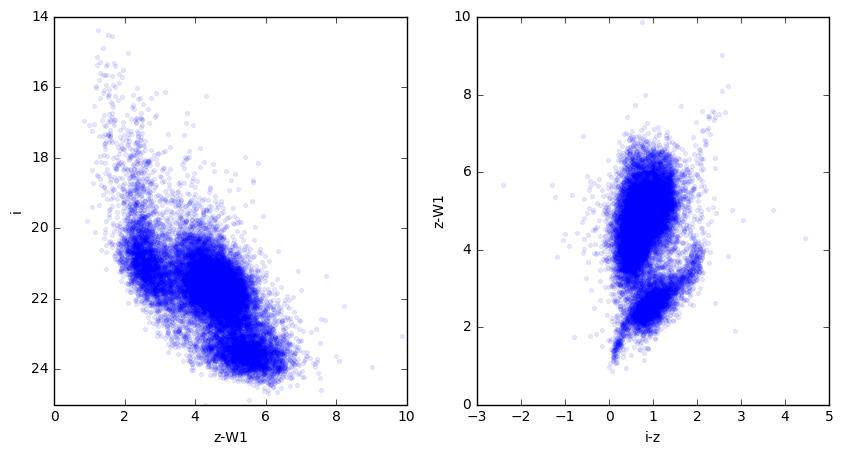

In [44]:
fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
ax1.plot(df["zmag"]-df["wise_w1mag"],df["imag"],'.',alpha=0.1)
ax1.axis([0,10,25,14])
ax1.set_xlabel('z-W1')
ax1.set_ylabel('i')

ax2.plot(df["imag"]-df["zmag"],df["zmag"]-df["wise_w1mag"],'.',alpha=0.1)
#ax2.axis([-2,4,1,8])
ax2.set_xlabel('i-z')
ax2.set_ylabel('z-W1')


### Selecting candidates

Let's take a closer look at those candidates with i-z colors greater then 2.0.

In [46]:
dfcand=df[(df["imag"]-df["zmag"])>2]
dfcand.tail()

,fieldid,id,ra,dec,umag,gmag,rmag,imag,zmag,uerr,gerr,rerr,ierr,zerr,depthflag,wise_id,wise_w1mag,wise_w1err,wise_w2mag,wise_w2err
18984,171,171.693072,194.572984,-77.413265,99.99,99.99,99.9900,23.5060,21.4896,9.99,9.99,9.990000,0.037148,0.013542,768,J125817.53-772447.7,15.045,0.034,14.742,0.050
19048,143,143.357304,330.078534,-76.359593,99.99,99.99,24.1651,22.9585,20.9505,9.99,9.99,0.353104,0.066035,0.017624,768,J220018.91-762134.2,17.739,0.163,17.602,0.482
19100,91,91.452798,163.335036,-42.190873,99.99,99.99,99.9900,20.9372,18.5298,9.99,9.99,9.990000,0.062298,0.093738,512,J105320.44-421127.3,15.915,0.045,16.216,0.157
19163,155,155.531898,109.932480,-49.606155,99.99,99.99,24.8357,23.6464,21.6067,9.99,9.99,0.382953,0.062253,0.024760,768,J071943.81-493622.4,16.514,0.055,16.166,0.120
19265,171,171.719693,196.660607,-77.756657,99.99,99.99,99.9900,23.7100,21.6918,9.99,9.99,9.990000,0.041333,0.016906,768,J130638.55-774523.8,16.319,0.056,16.074,0.127


### Simple Image Access setup

To use the Simple Image Access (SIA) service, we need to define the service URL and the size of the cutouts that we would like to retrieve.

In [47]:
DEF_ACCESS_URL = "http://zeus1.sdm.noao.edu/siapv1_images?"
DEF_SIZE = 0.0085  # degrees
svc = sia.SIAService (DEF_ACCESS_URL)
size = DEF_SIZE

### Selecting one object

Let's pick off the first candidate in the list and retrieve the list of images available as a VOTable.  

In [48]:
ra1=dfcand["ra"].iloc[0]
dec1=dfcand["dec"].iloc[0]
id1=dfcand["id"].iloc[0]

images = svc.search((ra1,dec1), (size/np.cos(dec1*np.pi/180), size), verbosity=2)

### Selecting the images for retrieval

We'll convert the VOTable to an AstroPy Table and limit the table by filter and to show only Stacked images.

In [53]:
imgTable = images.votable.to_table()
rTable=imgTable[(imgTable['proctype']=='Stacked') & (imgTable['obs_bandpass']=="r")]
iTable=imgTable[(imgTable['proctype']=='Stacked') & (imgTable['obs_bandpass']=="i")]
zTable=imgTable[(imgTable['proctype']=='Stacked') & (imgTable['obs_bandpass']=="z")]
imgTable

assoc_id,access_url,access_format,access_estsize,dataproduct_type,dataproduct_subtype,calib_level,dataset_length,im_nsubarrays,im_naxes,im_naxis,im_pixtype,im_wcsaxes,im_scale,obs_title,obs_id,obs_creator_name,obs_collection,obs_creation_type,obs_creation_date,facility_name,instrument_name,obs_bandpass,obs_datasource,proposal_id,obs_publisher_did,obs_release_date,preview,target_name,target_class,s_ra,s_dec,s_fov,s_region,s_calib_status,s_resolution,em_min,em_max,em_resolution,em_res_power,t_min,t_max,t_exptime,t_resolution,o_ucd,o_unit,pol_states,object,airmass,project_code,magzero,prodtype,seeing,fwhm,file_set_id,exptime,photflag,proctype,date_obs,mjd_obs,elliptic
,,,byte,,,,,,,,,,deg,,,,,,,,,,,,,,,,,deg,deg,deg,deg,,arcs,m,m,m,,d,d,s,s,,,,,,,,,,,,,,,,,
object,object,object,int32,object,object,int64,int64,int32,int32,object,object,object,object,object,object,object,object,object,object,str1,object,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
ct4m20160227t042801,"http://dldb1.sdm.noao.edu/cutout?fileRef=c4d_160227_043015_osi_r_v1.fits.fz&extn=1&POS=109.243656229,-54.9712849353&SIZE=0.0148087003195,0.0085",image/fits,374312,,,2,0,0,2,[9754 8847],,,[0.27],,ct4m20160227t042801,,2016A-0618,archival,,,DECam,r,,,ivo://noao/vo#ivoa.siav1_images:ivo://datalab.noao/nsa/c4d_160227_043015_osi_r_v1.fits.fz,,"http://dldb1.sdm.noao.edu/cutout?fileRef=c4d_160227_043015_osi_r_v1.fits.fz&extn=1&POS=109.243656229,-54.9712849353&SIZE=0.0148087003195,0.0085&preview=true",,,109.47499999999999,-54.636200000000002,--,,,--,5675.0,7155.0,--,--,--,--,--,--,,,,field_15,1.3,2016A-0618,29.884,image,0,3.82811,,240,,Stacked,2016-02-27T04:28:01.535164,557445.18612888,0
ct4m20140120t050931,"http://dldb1.sdm.noao.edu/cutout?fileRef=tu2167925.fits.fz&extn=42&POS=109.243656229,-54.9712849353&SIZE=0.0148087003195,0.0085",image/fits,310078,,,2,0,0,2,[2046 4094],,,[0.27],,ct4m20140120t050931,,2013B-0440,archival,,,DECam,r,,,ivo://noao/vo#ivoa.siav1_images:ivo://datalab.noao/nsa/tu2167925.fits.fz,,"http://dldb1.sdm.noao.edu/cutout?fileRef=tu2167925.fits.fz&extn=42&POS=109.243656229,-54.9712849353&SIZE=0.0148087003195,0.0085&preview=true",,,109.19799999999999,-54.945900000000002,--,,,--,5675.0,7155.0,--,--,--,--,--,--,,,,Field57,1.13,2013B-0440,30.529,image,0.658,0,,60,,InstCal,2014-01-20T05:09:31.148221,556677.21494385,0
ct4m20140120t051100,"http://dldb1.sdm.noao.edu/cutout?fileRef=tu2167043.fits.fz&extn=42&POS=109.243656229,-54.9712849353&SIZE=0.0148087003195,0.0085",image/fits,309808,,,2,0,0,2,[2046 4094],,,[0.27],,ct4m20140120t051100,,2013B-0440,archival,,,DECam,i,,,ivo://noao/vo#ivoa.siav1_images:ivo://datalab.noao/nsa/tu2167043.fits.fz,,"http://dldb1.sdm.noao.edu/cutout?fileRef=tu2167043.fits.fz&extn=42&POS=109.243656229,-54.9712849353&SIZE=0.0148087003195,0.0085&preview=true",,,109.197,-54.945500000000003,--,,,--,7100.0,8570.0,--,--,--,--,--,--,,,,Field57,1.13,2013B-0440,29.3778,image,0.658,0,,60,,InstCal,2014-01-20T05:11:00.152539,556677.21597399,0
ct4m20140120t051228,"http://dldb1.sdm.noao.edu/cutout?fileRef=tu2168990.fits.fz&extn=42&POS=109.243656229,-54.9712849353&SIZE=0.0148087003195,0.0085",image/fits,310978,,,2,0,0,2,[2046 4094],,,[0.27],,ct4m20140120t051228,,2013B-0440,archival,,,DECam,z,,,ivo://noao/vo#ivoa.siav1_images:ivo://datalab.noao/nsa/tu2168990.fits.fz,,"http://dldb1.sdm.noao.edu/cutout?fileRef=tu2168990.fits.fz&extn=42&POS=109.243656229,-54.9712849353&SIZE=0.0148087003195,0.0085&preview=true",,,109.197,-54.9452,--,,,--,8500.0,10020.0,--,--,--,--,--,--,,,,Field57,1.13,2013B-0440,29.0616,image,0.579,0,,60,,InstCal,2014-01-20T05:12:28.163768,556677.21699264,0
ct4m20140125t050604,"http://dldb1.sdm.noao.edu/cutout?fileRef=tu2162471.fits.fz&extn=42&POS=109.243656229,-54.9712849353&SIZE=0.0148087003195,0.0085",ima

Now we pick off the URLs of the r, i, and z cutouts, and take only the first one from each potential list.

In [50]:
rurl=((rTable['preview']).data).data[0]
iurl=((iTable['preview']).data).data[0]
zurl=((zTable['preview']).data).data[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

### Retrieving the image cutouts

Now we retrieve the cutouts.  This could be done through parallel threads to speed things up, but here we keep it simple and do it sequentially.

In [10]:
rimg = plt.imread(astropy.utils.data.download_file(rurl,cache=True,show_progress=False,timeout=120))
iimg = plt.imread(astropy.utils.data.download_file(iurl,cache=True,show_progress=False,timeout=120))
zimg = plt.imread(astropy.utils.data.download_file(zurl,cache=True,show_progress=False,timeout=120))

### Displaying the cutouts

Now let's show the cutouts.

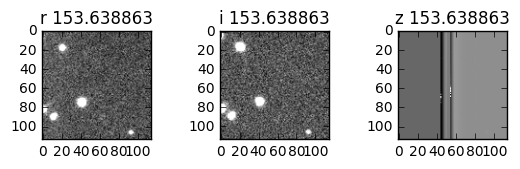

In [11]:
a1=plt.subplot2grid((2,8),(0,0),rowspan=2,colspan=2)
imgplot = plt.imshow(rimg)
a1.set_title('r '+id.astype('string'))

a2=plt.subplot2grid((2,8),(0,3),rowspan=2,colspan=2)
imgplot = plt.imshow(iimg)
a2.set_title('i '+id.astype('string'))

a2=plt.subplot2grid((2,8),(0,6),rowspan=2,colspan=2)
imgplot = plt.imshow(zimg)
a2.set_title('z '+id.astype('string'))

To go through the whole list of cutouts, the code from this notebook would be best put into a Python script and run from the command line, saving the images or making a figure showing all of the candidate objects at once.